In [30]:
from warnings import filterwarnings
import numpy as np
import pandas as pd
import nltk
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
import re
from string import punctuation
import spacy

In [2]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

###  Text Processing

In [3]:
df = pd.read_csv("datasets/amazon_reviews.csv", sep=',')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [4]:
###############################
# Normalizing Case Folding
###############################
df["reviewText"] = df["reviewText"].astype("str").apply(lambda x: x.lower())

In [5]:
df["reviewText"]

0                                              no issues.
1       purchased this for my device, it worked as adv...
2       it works as expected. i should have sprung for...
3       this think has worked out great.had a diff. br...
4       bought it with retail packaging, arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable. it ...
4913    good amount of space for the stuff i want to d...
4914    i've heard bad things about this 64gb micro sd...
Name: reviewText, Length: 4915, dtype: object

In [6]:
###############################
# Punctuations
###############################
def remove_punctuations(text):
    new_text = []
    for word in text.split():  # metni kelimelere ayır
        w = re.sub(r'[^\w\s]', '', word)  # Noktalama işaretlerini kaldır
        w = re.sub(r'_', '', w)  # Alt çizgiyi kaldır
        new_text.append(w)  # Düzenlenen kelimeyi listeye ekle
    
    return " ".join(new_text)  # Listeyi string olarak birleştir

df["reviewText"] = df["reviewText"].apply(lambda x: remove_punctuations(x))

In [7]:
df["reviewText"]

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this 64gb micro sd ...
Name: reviewText, Length: 4915, dtype: object

In [8]:
###############################
# Numbers
###############################
df['reviewText'] = df['reviewText'].str.replace(r'\d', '', regex=True)

In [9]:
df["reviewText"]

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk gb class  to use with my...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this gb micro sd ca...
Name: reviewText, Length: 4915, dtype: object

In [10]:
###############################
# Stopwords
###############################
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
sw = stopwords.words("english")
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [12]:
df["reviewText"] = df["reviewText"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df["reviewText"]

0                                                  issues
1       purchased device worked advertised never much ...
2       works expected sprung higher capacity think ma...
3       think worked greathad diff bran gb card went s...
4       bought retail packaging arrived legit orange e...
                              ...                        
4910    bought sandisk gb class use htc inspire months...
4911    used extending capabilities samsung galaxy not...
4912    great card fast reliable comes optional adapte...
4913          good amount space stuff want fits gopro say
4914    ive heard bad things gb micro sd card crapping...
Name: reviewText, Length: 4915, dtype: object

In [13]:
###############################
# Lemmatization
###############################
nltk.download("wordnet")
df["reviewText"] = df["reviewText"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
df["reviewText"]

0                                                   issue
1       purchased device worked advertised never much ...
2       work expected sprung higher capacity think mad...
3       think worked greathad diff bran gb card went s...
4       bought retail packaging arrived legit orange e...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used extending capability samsung galaxy note ...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: reviewText, Length: 4915, dtype: object

In [15]:
###############################
# Lemmatization
###############################

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

In [16]:
words = ["Eating", "ate", "eat", "eats", "adjustable", "ability", "rafting", "meeting"]
for word in words:
    print(word, "|", stemmer.stem(word))

Eating | eat
ate | ate
eat | eat
eats | eat
adjustable | adjust
ability | abil
rafting | raft
meeting | meet


In [17]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("eating eats eat ate ability adjustable rafting meeting")

for token in doc:
    print(token, '|', token.lemma_)

eating | eat
eats | eat
eat | eat
ate | ate
ability | ability
adjustable | adjustable
rafting | rafting
meeting | meeting


In [18]:
##################################################
# 2. Text Visualization
##################################################


###############################
# Terim Frekanslarının Hesaplanması (Term-Frequency Inverse-Document Frequency TF-IDF)
###############################
tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [19]:
tf

,index,0
0,issue,609.00
1,purchased,344.00
2,device,584.00
3,worked,460.00
4,advertised,111.00
...,...,...
8996,unexpectedlythen,1.00
8997,extending,1.00
8998,alike,1.00
8999,stealwould,1.00


In [20]:
tf.columns = ["word", "tf"]

In [21]:
tf.sort_values(by="tf", ascending=False)

,word,tf
29,card,5537.00
14,work,2044.00
7,phone,1909.00
43,gb,1756.00
110,great,1446.00
...,...,...
4898,mhz,1.00
4897,enhances,1.00
4894,doesbefore,1.00
4892,phonejust,1.00


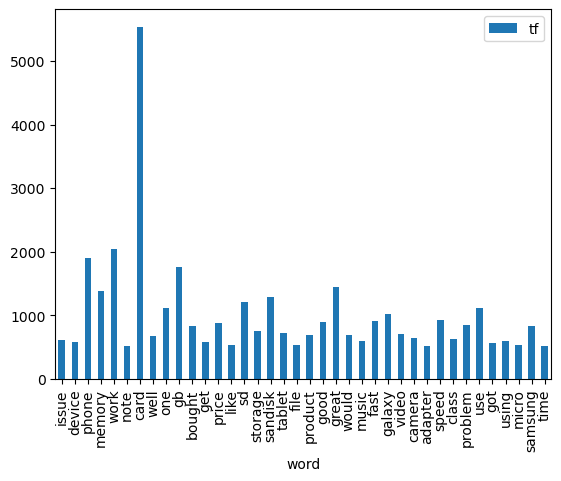

In [23]:
###############################
# Barplot
###############################
import matplotlib.pyplot as plt
tf[tf["tf"] > 500].plot.bar(x="word", y="tf")
plt.show()

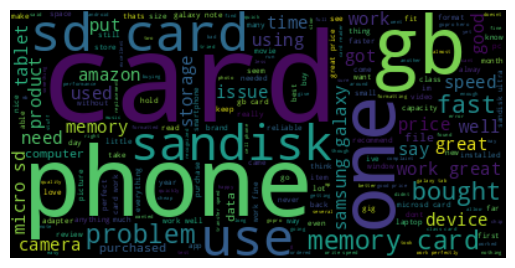

In [27]:
###############################
# Wordcloud
###############################
text = " ".join(w for w in df.reviewText)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

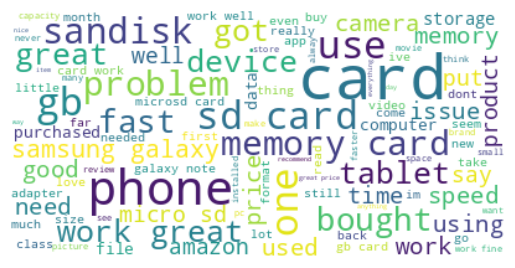

In [29]:
###############################
# Customizing Wordcloud through Constructor Parameters
###############################
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud_whitebg.png")

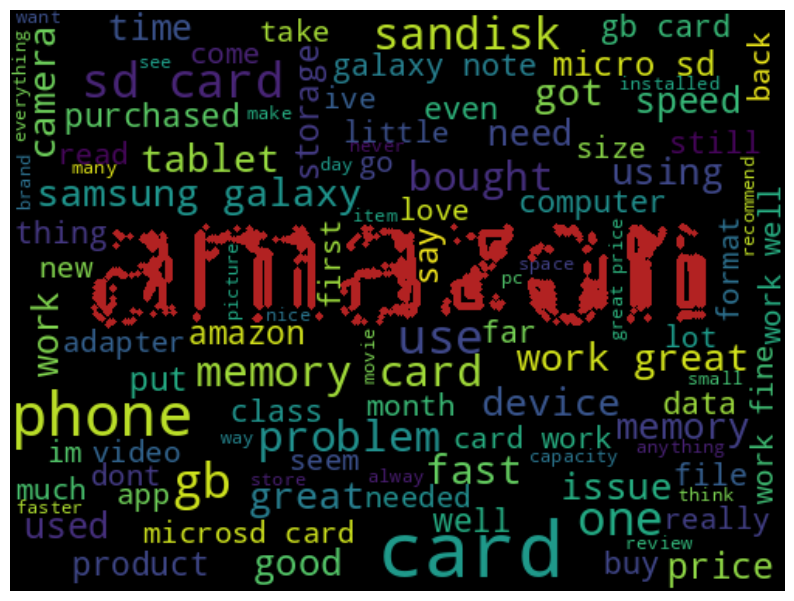

In [37]:
###############################
# Şablonlara Göre Wordcloud
###############################
file_path = "images/amazon_logo.jpg"
amazon_mask = np.asarray(Image.open(file_path))

wc = WordCloud(background_color="black",
                      max_words=100,
                      max_font_size=50,
                      mask=amazon_mask,
                      contour_width=5,
                      contour_color="firebrick"
                        )

wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()